<a href="https://colab.research.google.com/github/syifanurul/Malaria-Cells-Image-Recognition/blob/master/Malaria_Cell_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MALARIA CELLS IMAGE RECOGNITION**

Classification of Malaria Cells Identification in Red Blood Cells Using Tensorflow


**Group Members:** 
1. Raynald Masli
2. Syifa Nurul Fatimah

## **Import Packages**

In [0]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## **Download Data from Kaggle**

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynaldmasli","key":"f0b16ad96cd92fe3c64f0b6430d2907b"}'}

In [0]:
!ls -lha kaggle.json #Make sure that kaggle.json has already upload

-rw-r--r-- 1 root root 68 Apr  1 03:48 kaggle.json


In [0]:
!pip install -q kaggle #kaggle library installation

In [0]:
#Access the Kaggle dataset for data input
!mkdir -p~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list #Asking for Kaggle dataset


mkdir: invalid option -- '~'
Try 'mkdir --help' for more information.
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  729MB  2020-03-27 23:46:53          38143  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07             31  
sobhanmoosavi/us-accidents                                     US Accidents (3.0 million records)                  199MB  2020-01-17 04:45:09          11801  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        150KB  2020-03-31 12

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #malaria-cells-images download from Kaggle

 98% 664M/675M [00:10<00:00, 35.2MB/s]
100% 675M/675M [00:10<00:00, 67.3MB/s]


## **Data Preparation**

In [0]:
np.random.seed(1000)

In [0]:

import zipfile

#Extract the file from zip file
images = zipfile.ZipFile("/content/cell-images-for-detecting-malaria.zip", 'r')
images.extractall("/content")
images.close()


In [0]:
#Assign the images into either the infected cells and uninfected cells 

infected_cells = os.listdir("/content/cell_images/Parasitized")
uninfected_cells = os.listdir("/content/cell_images/Uninfected")

In [0]:
#Transform and resize the all the images into the 75x75 matrices of pixels
import keras.preprocessing.image as im
picture = []
label = []

for infect in infected_cells :
  try :
    if infect != 'Thumbs.db':
      image = "/content/cell_images/Parasitized/"+infect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(1)

  except FileNotFoundError:
    continue

for uninfect in uninfected_cells :
  try :
    if uninfect != 'Thumbs.db':
      image = "/content/cell_images/Uninfected/"+uninfect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(0)

  except FileNotFoundError:
    continue


In [0]:
#Initialization of image data parameters
data = np.array(picture)
labels = np.array(label)

#Checks the total of rgb images array and the labels of them
np.save('data', data)
np.save('labels', labels)

print ('data : {}, labels : {}'.format(data.shape, labels.shape))

data : (27558, 75, 75, 3), labels : (27558,)


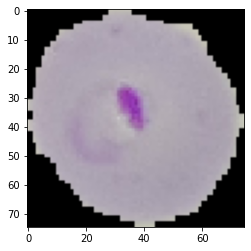

In [0]:
#Plot an example of the data
plt.imshow(data[3])

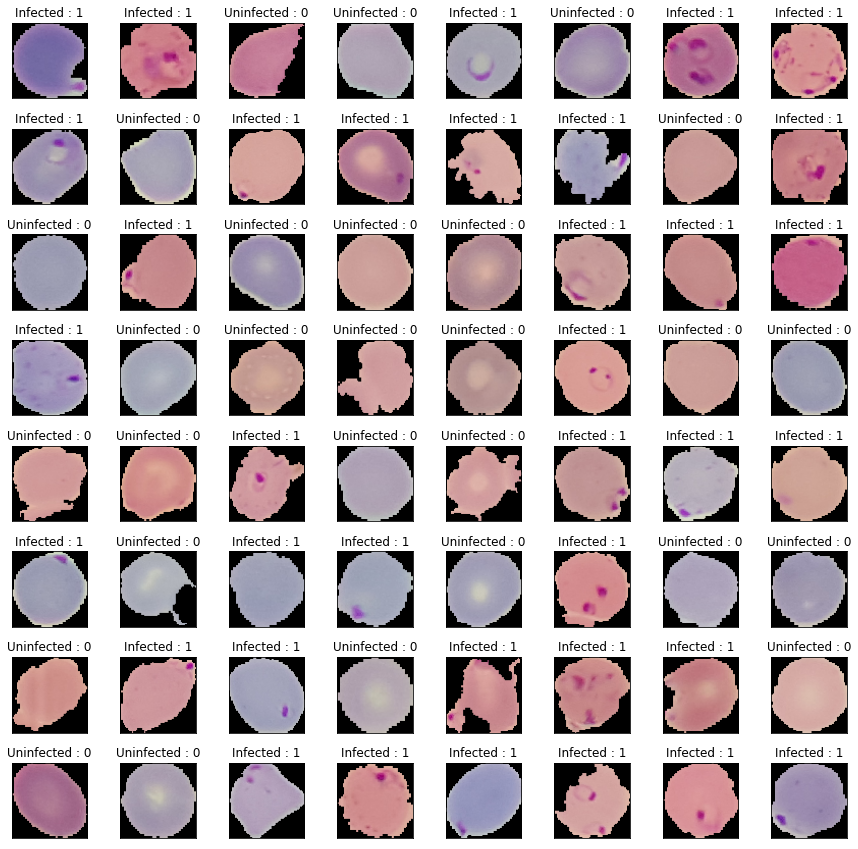

In [0]:
#Plot and preview the pictures and its label
plt.figure(num = 1, figsize = (15,15))

for n in range (1,65) :
  val = np.random.randint(0, data.shape[0], 1)
  plt.subplot(8, 8, n)
  plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
  plt.imshow(data[val[0]])
  plt.title('{} : {}'.format('Uninfected' if labels[val[0]] == 0 else 'Infected', labels[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()

In [0]:
#Data Randomization
arranger = np.arange(data.shape[0])
np.random.shuffle(arranger)
data = data[arranger]
labels = labels[arranger]

# **Data Preparation Conclusion**


*   Images are transformed into 75x75 pixels matrix in feature 'data' 
*   Labels of the images (infected and uninfected) is determined in feature 'labels'
*   All the dataset has been randomized





## **Model Creation**

1.   Training and testing dataset 

2.   Build the model

2.   Model summary

3.   Compile the model

4.   Train and test the model

5.   Save the model

6.   Visualize training result



### **Training and Tesing Dataset**

In [0]:
#Split the data into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.25)

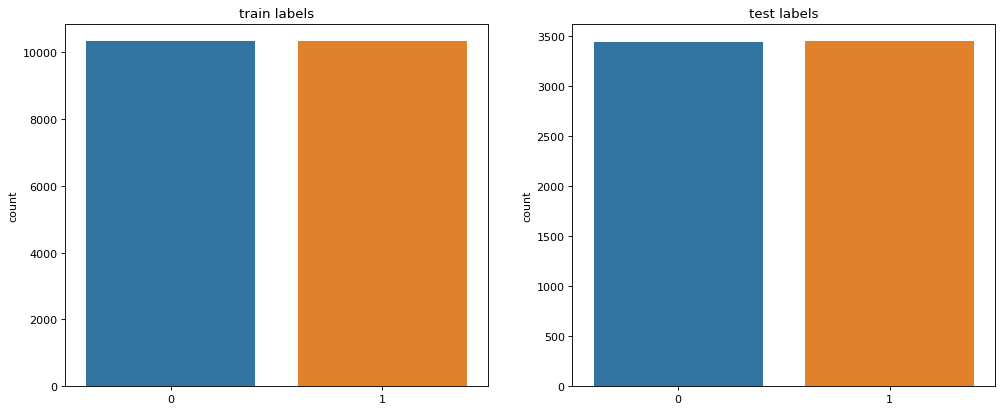

In [0]:
#Data amount confirmation
plt.figure(1, figsize = (15,6), dpi = 80)
num_fig = 0

for pic, title in zip ([Y_train, Y_test], ['train labels', 'test labels']) :
  num_fig += 1
  plt.subplot(1, 2, num_fig)
  sb.countplot (x = pic)
  plt.title(title)

plt.show()

### **Build the Model**

In [0]:
#Create model with function
def Convmodel (fill_layer, mode = 'relu'):
  model = Sequential()
  model.add(Conv2D(fill_layer.pop(0), (3,3), input_shape = (75,75,3)))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\',and \'prelu\'')

  for i,neurons in enumerate (fil_llayer):  
    model.add(Conv2D(neurons, (3,3), input_shape = (75,75,3)))
    if mode == 'relu' : model.add(Activation('relu'))  
    elif mode == 'leakyrelu' : model.add(LeakyReLU())
    elif mode == 'prelu' : PReLU(Constant(value = 0.25))
    else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
    model.add(MaxPooling2D((2,2)))

  model.add(Flatten())
  model.add(Dense(512))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dropout(0.5))
  model.add(Dense(64))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dense(1, activation = 'sigmoid'))

  return model

### **Model Summary**

In [0]:
model = Convmodel([16,32,64,128,128], mode = 'leakyrelu')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 73, 73, 16)        448       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 71, 71, 32)        4640      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 71, 71, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 33, 33, 64)       

### **Compile the Model**

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])

### **Train and Test the Model**

In [0]:
batch_size = 32
epochs = 75
ntrain = len(X_train)
nval = len(X_test)

In [0]:
train_datagen = ImageDataGenerator(rescale = 1/225, horizontal_flip = True, vertical_flip = True, rotation_range = 30)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [0]:
train_datagen = train_datagen.flow(X_train, Y_train, batch_size = batch_size)
test_datagen = test_datagen.flow(X_test, Y_test, batch_size = batch_size)

In [0]:
history = model.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs, 
                              shuffle = True)

Epoch 1/75
645/645 [==============================] - 177s 275ms/step - loss: 0.3036 - accuracy: 0.8739
Epoch 2/75
645/645 [==============================] - 178s 275ms/step - loss: 0.2167 - accuracy: 0.9240
Epoch 3/75
645/645 [==============================] - 178s 276ms/step - loss: 0.2066 - accuracy: 0.9298
Epoch 4/75
645/645 [==============================] - 177s 275ms/step - loss: 0.2039 - accuracy: 0.9311
Epoch 5/75
645/645 [==============================] - 180s 279ms/step - loss: 0.1954 - accuracy: 0.9320
Epoch 6/75
645/645 [==============================] - 177s 274ms/step - loss: 0.1945 - accuracy: 0.9325
Epoch 7/75
645/645 [==============================] - 177s 275ms/step - loss: 0.1894 - accuracy: 0.9341
Epoch 8/75
645/645 [==============================] - 177s 275ms/step - loss: 0.1856 - accuracy: 0.9350
Epoch 9/75
645/645 [==============================] - 177s 274ms/step - loss: 0.1830 - accuracy: 0.9364
Epoch 10/75
645/645 [==============================] - 177s 275m

### **Save the Model**

In [0]:
model.save_weights('model_weights.1')
model.save('model_keras.1')

INFO:tensorflow:Assets written to: model_keras.1/assets


### **Visualize Training Result**

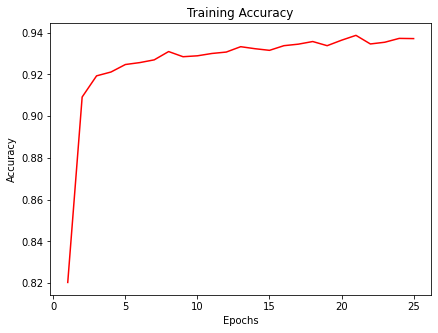

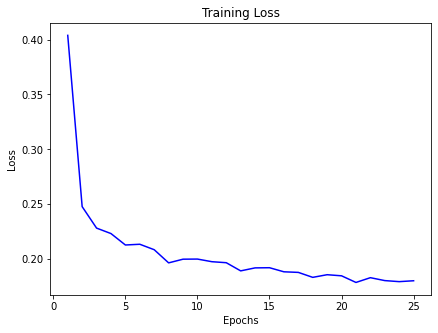

In [0]:
#Plot the training accuracy and loss
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)
num_fig = 0

for met, col, ylab, title in zip ([acc, loss], ['red', 'blue'], ['Accuracy', 'Loss'], ['Training Accuracy', 'Training Loss']):
  plt.figure(figsize = (15,5))
  num_fig += 1
  plt.subplot(1,2, num_fig)
  plt.plot(epochs_range, met, col)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(ylab)

plt.show()

Test Accuracy = 83.76% 
 Test Prediction = 98.62% 
 Test Recall = 75.84% 
 Test f1 Score = 85.75%


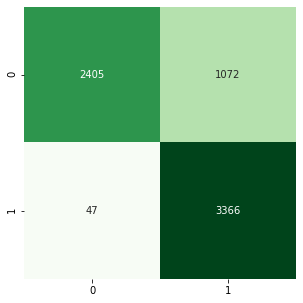

In [0]:
#Test result conclusion
import tensorflow.keras.metrics as mts
def conc_model(model):
  plt.figure(figsize = (5,5))
  y_pred = model.predict(X_test)
  y_pred = np.where(y_pred > 0.5, 1, 0)
  conf_matrix = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred))
  acc = (conf_matrix[0,0] + conf_matrix[1,1])/(conf_matrix[0,0] + conf_matrix[1,1] + conf_matrix[1,0] + conf_matrix[0,1])*100
  prec = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0])*100
  rec = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[0,1])*100
  f1_score = 2*prec*rec/(prec + rec)
  print('Test Accuracy = {:.2f}% \n Test Prediction = {:.2f}% \n Test Recall = {:.2f}% \n Test f1 Score = {:.2f}%'.format(acc, prec, rec, f1_score))
  sb.heatmap(conf_matrix, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.show()

conc_model(model)

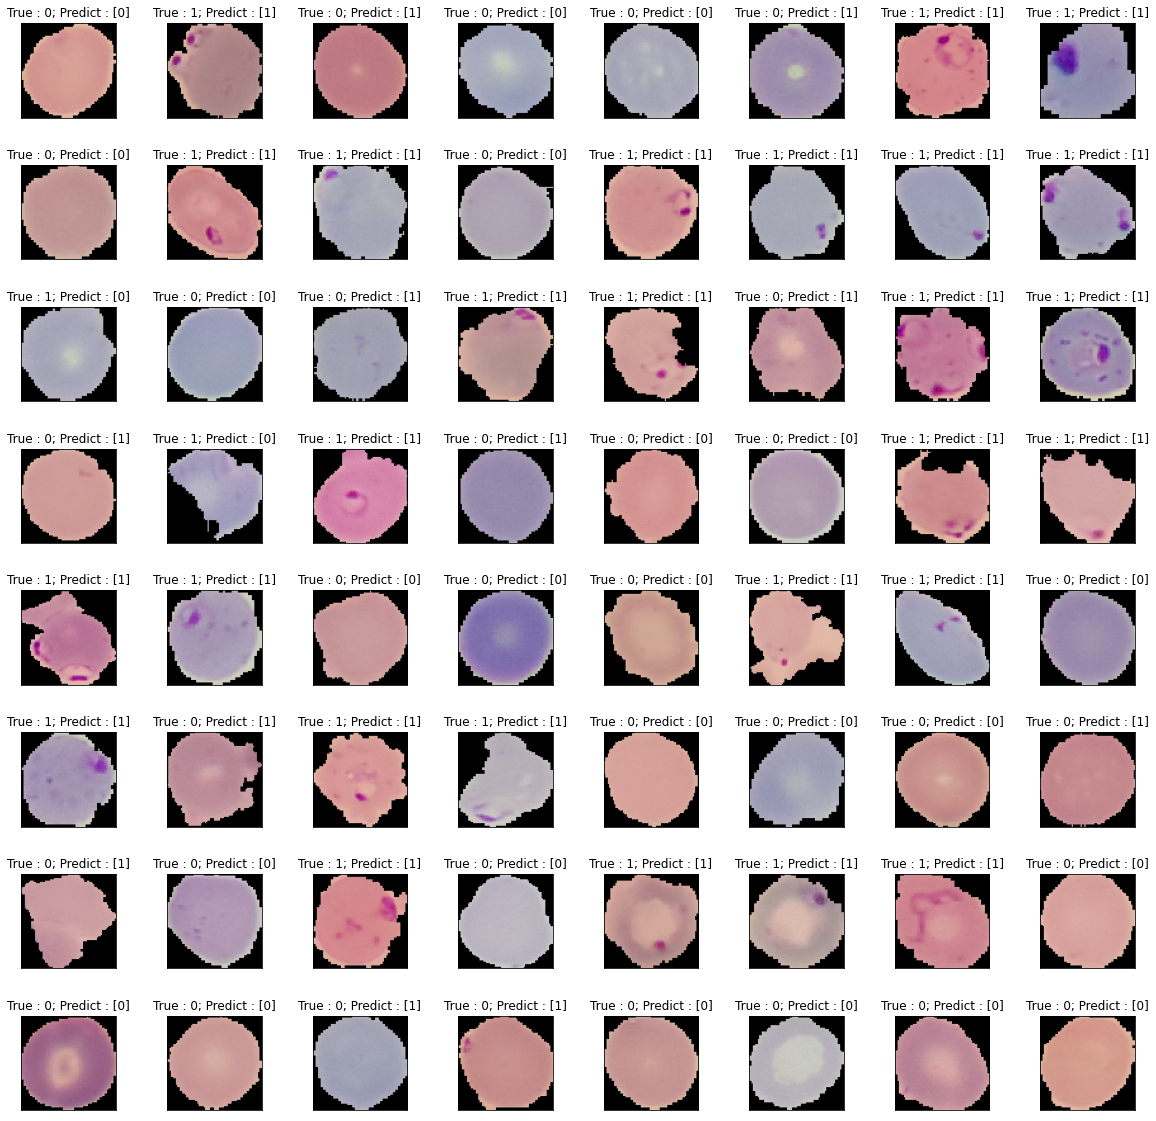

In [0]:
#plot the train test result
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

plt.figure(num = 1, figsize = (20,20))

for n in range (1,65) :
  val = np.random.randint(0, X_test.shape[0], 1)
  plt.subplot(8, 8, n)
  plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
  plt.imshow(X_test[val[0]])
  plt.title('True : {}; Predict : {}'.format(Y_test[val[0]], y_pred[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()